# Causal Interpretation for Ames Housing Price

This notebook uses the Ames Housing dataset to showcase how we can interpret a blackbox model from both the **correlation and causation** perspective by leveraging the power of model interpretation tools like [SHAP](https://shap.readthedocs.io/en/latest/index.html) and [EconML](https://aka.ms/econml). This housing dataset collects house prices and characteristics for homes sold in Ames, Iowa from the period of 2006 to 2010. We start with a linear regression to build intuition. We then train a fine-tuned predictive ML model and use SHAP to better understand the correlations between features and target and which features are the strongest predictors. Finally, we train a separate causal model using EconML, which identifies features that have a **direct causal effect** on housing price, instead of just predicting the housing price given a set of characteristics.

Note: A previous version of this notebook used the Boston Housing dataset. Due to ethical concerns with the Boston Housing dataset, we have decided to redo the analysis on the similar Ames Housing dataset. More details can be found on the sklearn page for the [Boston Housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html).

This notebook includes the following sections:
1. [A Gentle Start: Linear Regression](#A-Gentle-Start:-Linear-Regression)
2. [Train a Fine-tuned Predictive ML Model](#Train-a-Fine-tuned-Predictive-ML-Model)
3. [Correlation Interpretation](#Correlation-Interpretation)
    * Feature Importance -- Learn the top predictors for a given ML model
4. [Causal Interpretation](#Causal-Interpretation)
    * Direct Causal Effect -- Do certain house characteristics have a direct effect on home value?
    * Segmentation -- How do different type of houses respond differently to having a fireplace?
    * Policy Analysis -- What is the best policy considering cost?
    * What If Analysis -- How does the overall housing price change if every home had a fireplace?
    * Cohort Analysis -- What is the causal effect on a new dataset?
    

In [ ]:
%pip install lightgbm==4.5.0 econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 139.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: shap
    Found existin

In [ ]:
%pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 9.7 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
%pip install shap
# %pip install --force-reinstall numpy


# Import Python Libraries

In [ ]:
# Some imports to get us started
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import shap

import xgboost

%matplotlib inline

# Ordinary Linear Regression

### Data Description

The data contain features of Ames homes sold between 2006 and 2010 and was originally introduced by Dean De Cock. [Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project](http://jse.amstat.org/v19n3/decock.pdf), Journal of Statistics Education Volume 19, Number 3(2011)

Below is a sample of the features and their descriptions:

Feature Name|Description
:--- |:---
**Neighborhood**|Physical locations within Ames city limits
**BsmtFullBath**|Basement full bathrooms
**Alley**|Type of alley access to property
**BsmtFinType1**|Rating of basement finished area
**Fence**|Fence quality
**MiscFeature**|Miscellaneous feature not covered in other categories
**RoofStyle**|Type of roof
**GrLivArea**|Above grade (ground) living area square feet
**SalePrice**|Sale price of home

A more complete data dictionary can be found on the [OpenML page for the dataset](https://www.openml.org/d/42165).

We start with a linear regression to learn the conditional correlation between each predictor and the outcome variable. The coefficients  tell us how the housing price will change with one unit increase of each feature (holding all other features constant), and the p-value tells us the variable significance.

Under certain strong assumptions, the coefficients from linear regression can lead us to a causal interpretation too. But as we will see later in this notebook, techniques like DoubleML can allow us to use the predictive power of machine learning to do causal inference while also minimizing assumptions about the functional form of our data (e.g. additive separability).

# Fetch AMES Housing Dataset from OpenML

In [ ]:
from sklearn.datasets import fetch_openml

ames_housing = fetch_openml(name="house_prices", as_frame = True)

In [ ]:
ames_housing

{'data':         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 0        1          60       RL         65.0     8450   Pave   NaN      Reg   
 1        2          20       RL         80.0     9600   Pave   NaN      Reg   
 2        3          60       RL         68.0    11250   Pave   NaN      IR1   
 3        4          70       RL         60.0     9550   Pave   NaN      IR1   
 4        5          60       RL         84.0    14260   Pave   NaN      IR1   
 ...    ...         ...      ...          ...      ...    ...   ...      ...   
 1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
 1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
 1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
 1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
 1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   
 
      LandContour Utilities  .

# Create Dataframe from the raw Ames Housing Dataset

In [ ]:
# retrieve just the data part of Ames
ames_df = ames_housing.data

# display output
print(ames_df.shape)

(1460, 80)


In [ ]:
ames_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


# Data Pre-processing Pipeline with SKLEARN

Minor feature engineering via feature creation/removal, and outlier removal

In [ ]:
Xy = (
    ames_df

    # add target feature
    .assign(SalePrice = ames_housing.target)
    .set_index('Id')

    # drop outliers with missing detail in this column
    .loc[
        lambda df: df['MasVnrType'].notna()
    ]

    # drop outlier with missing electrical row
    .loc[
        lambda df: df['Electrical'].notna()
    ]

    # add interpretable year columns
    .assign(
        AgeAtSale = lambda df: df['YrSold'].sub(df['YearBuilt']),

        # clip lower for outlier
        YearsSinceRemodel = lambda df: df['YrSold'].sub(df['YearRemodAdd']).clip(lower = 0),

        HasDeck = lambda df: df['WoodDeckSF'].gt(0).map(int),

        HasPorch = lambda df:
          df[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']]
          .gt(0)
          .max(axis = 1)
          .map(int),

        HasFireplace = lambda df: df['Fireplaces'].clip(upper = 1).map(int),
        HasFence = lambda df: df['Fence'].notna().map(int)
    )

    # drop year columns
    .drop(
        columns = [
            'GarageYrBlt', 'YearBuilt', 'YrSold', 'YearRemodAdd',
            'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
            'FireplaceQu', 'Fireplaces',
            'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
            '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'PoolArea'
        ]
    )

    # fill missing with 0
    .assign(LotFrontage = lambda df: df['LotFrontage'].fillna(0))

    # rest of missing values are in categorical columns, so fill with NA category
    .fillna('NA')

    # add constant column for OLS
    .assign(Intercept = 1)
)

Xy

,MSSubClass,MSZoning,LotFrontage,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleType,SaleCondition,SalePrice,AgeAtSale,YearsSinceRemodel,HasDeck,HasPorch,HasFireplace,HasFence,Intercept
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,208500,5,5,0,1,0,0,1
2,20,RL,80.0,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,...,WD,Normal,181500,31,31,1,0,1,0,1
3,60,RL,68.0,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,...,WD,Normal,223500,7,6,0,1,1,0,1
4,70,RL,60.0,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,...,WD,Abnorml,140000,91,36,0,1,1,0,1
5,60,RL,84.0,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,...,WD,Normal,250000,8,8,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,175000,8,7,0,1,1,0,1
1457,20,RL,85.0,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,210000,32,22,1,0,1,1,1
1458,70,RL,66.0,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,266500,69,4,0,1,1,1,1


## Identify Categorical Data

In [ ]:
# identify categorical columns for one hot encoding
categorical = list(
    Xy
    .apply(lambda series: series.dtype)
    .loc[
        lambda df: df.eq('object')
    ]
    .index
) + ['MSSubClass']


# Set the Outcome or Target

In [ ]:
X = Xy.drop(columns = 'SalePrice')


# onehot encode categorical data
X_ohe = (
    X
    .pipe(pd.get_dummies, prefix_sep = '_OHE_', columns = categorical, dtype='uint8')
)


# the outcome or target
y = Xy['SalePrice']

# Building the intuition - Ordinary Least Squares

In [ ]:
# Train a linear regression using statsmodels
model = sm.OLS(y, X_ohe)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     59.41
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        04:46:37   Log-Likelihood:                -16565.
No. Observations:                1451   AIC:                         3.362e+04
Df Residuals:                    1206   BIC:                         3.491e+04
Df Model:                         244                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
LotFrontage                   9.1690     24.385      0.376      0.707     -38.674      57.012
OverallQual                6443.4507   1098.337      5.867      0.000    4288.587    8598.315
OverallCond                5761.3467    921.305      6.253      0.000    3953.808    7568.885
GrLivArea                    71.2724      3.926     18.155      0.000      63.570      78.975
BsmtFullBath               7808.0939   1862.581      4.192      0.000    4153.836    1.15e+04
BsmtHalfBath               2704.3964   3161.287      0.855      0.392   -3497.837    8906.630
FullBath                   4353.2284   2358.076      1.846      0.065    -273.159    8979.616
HalfBath                   1125.2313   2213.287      0.508      0.611   -3217.089    5467.552
BedroomAbvGr              -4678.0376   1473.399     -3.175      0.002   -7568.747   -1787.328
KitchenAbvGr              -1.089e+04   6648.976     -1.639      0.102   -2.39e+04    2150.473
TotRmsAbvGrd               1013.7051   1016.102      0.998      0.319    -979.818    3007.228
GarageCars                 8663.3405   1708.010      5.072      0.000    5312.340     1.2e+04
MiscVal                       9.0392      6.684      1.352      0.177      -4.074      22.153
MoSold                     -510.0946    260.244     -1.960      0.050   -1020.675       0.486
AgeAtSale                  -305.4555     85.143     -3.588      0.000    -472.501    -138.410
YearsSinceRemodel           -27.7465     58.392     -0.475      0.635    -142.308      86.815
HasDeck                    1621.8650   1585.671      1.023      0.307   -1489.115    4732.845
HasPorch                   1870.3246   1739.962      1.075      0.283   -1543.365    5284.014
HasFireplace               2375.0085   1818.079      1.306      0.192   -1191.941    5941.958
HasFence                  -5877.2263   2031.768     -2.893      0.004   -9863.419   -1891.033
Intercept                 -8887.1036   3683.133     -2.413      0.016   -1.61e+04   -1661.044
MSZoning_OHE_'C (all)'    -2.978e+04   8731.959     -3.411      0.001   -4.69e+04   -1.27e+04
MSZoning_OHE_FV            1.271e+04   6497.547      1.957      0.051     -33.757    2.55e+04
MSZoning_OHE_RH            4234.7895   6421.424      0.659      0.510   -8363.614    1.68e+04
MSZoning_OHE_RL            4630.5784   3487.791      1.328      0.185   -2212.233    1.15e+04
MSZoning_OHE_RM            -682.4301   3937.317     -0.173      0.862   -8407.183    7042.323
Street_OHE_Grvl           -8776.6589   6992.025     -1.255      0.210   -2.25e+04    4941.225
Street_OHE_Pave            -110.4448   6575.318     -0.017      0.987    -1.3e+04    1.28e+04
Alley_OHE_Grvl            -1810.1857   3604.374     -0.502      0.616   -8881.726    5261.355
Alley_OHE_NA              -4693.0936   2616.409     -1.794      0.073   -98

# Train a Fine-tuned Predictive ML Model

## Split data into training and testing (the actual prediction)

In [ ]:
# Split data into train and test
from sklearn.model_selection import train_test_split

x_train_ohe, x_test_ohe, x_train, x_test, y_train, y_test = train_test_split(
    X_ohe, X, y, test_size=0.2, random_state=0
)

## Set hyper-parameters for the LGBM Regressor

In [ ]:
# train a lightGBM regression model
est = LGBMRegressor()
param_grid = {"learning_rate": [0.1, 0.05, 0.01], "max_depth": [3, 5, 10]}
search = GridSearchCV(est, param_grid, n_jobs=-1)

In [ ]:
lightgbm_model = LGBMRegressor()

In [ ]:
param_grid = {"learning_rate": [0.1, 0.05, 0.01], "max_depth": [3, 5, 10]}
search_lightgbm_model = GridSearchCV(lightgbm_model, param_grid, n_jobs=-1)

## Now train LGMB Regressor

In [ ]:
search_lightgbm_model.fit(x_train_ohe, y_train)
print("Best estimator: ", search_lightgbm_model.best_params_)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 1160, number of used features: 184
[LightGBM] [Info] Start training from score 181207.644828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
param_grid = {"learning_rate": [0.1], "max_depth": [3]}
search = GridSearchCV(est, param_grid, n_jobs=-1)

# XGBoost

In [ ]:
xgboost_model = xgboost.XGBRFRegressor()

In [ ]:
param_grid = {"learning_rate": [0.1], "max_depth": [3]}
search_xgboost_model = GridSearchCV(xgboost_model, param_grid, n_jobs=-1)

In [ ]:
search_xgboost_model.fit(x_train_ohe, y_train)
print("Best estimator: ", search_xgboost_model.best_params_)

Best estimator:  {'learning_rate': 0.1, 'max_depth': 3}


In [ ]:
print("Test set score: ", search_xgboost_model.best_estimator_.score(x_test_ohe, y_test))

Test set score:  0.15424048900604248


# Correlation Interpretation
## Feature Importance - SHAP Value

## We explain this ML model by understanding the top important features to predict the housing price, internally using **shap value**.

In [ ]:
fitted_model = search_xgboost_model.best_estimator_

In [ ]:
fitted_model_lightgbm = search_lightgbm_model.best_estimator_

In [ ]:
# use interventional approach
background = shap.maskers.Independent(x_train_ohe, max_samples=1000)
explainer = shap.TreeExplainer(
    fitted_model_lightgbm, data=background, feature_names=X_ohe.columns
)
shap_values = explainer(x_test_ohe)

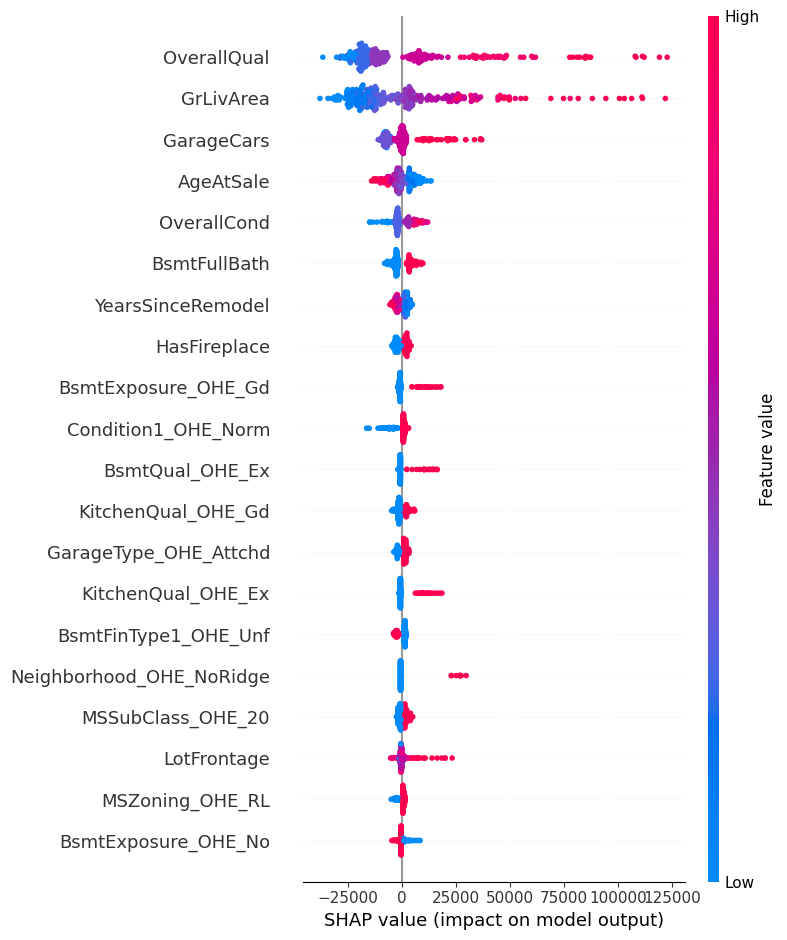

In [ ]:
# plot the feature importance
shap.summary_plot(shap_values, x_test_ohe)

## From the summary plot above, we could see the **most important features** sorted by their importance level. It tells us that houses that measure high in overall quality, square footage, and are also relatively new will have a higher housing price.

# What about XGBoost?

In [ ]:
fitted_model_xgboost_model = search_xgboost_model.best_estimator_

In [ ]:
# use interventional approach
background = shap.maskers.Independent(x_train_ohe, max_samples=1000)
explainer = shap.TreeExplainer(
    fitted_model_xgboost_model, data=background, feature_names=X_ohe.columns
)
shap_values = explainer(x_test_ohe)

In [ ]:
# plot the feature importance
shap.summary_plot(shap_values, x_test_ohe)

# Causal Interpretation
## Direct Causal Effect --  Do certain house characteristics have a direct effect on home value?

## We've seen which features are good predictors of home value, but are these features also causally signficiant? Below we use the CausalAnalysis class to assess the causal effects of certain house characteristics on home value.

In [ ]:
# order feature names according to shap values
vals = np.abs(shap_values.values).mean(0)

# collect data for features importances
feature_importance = pd.DataFrame(
    list(zip(shap_values.feature_names, vals)), columns=["features", "importance"]
)


feature_importance.sort_values(by=["importance"], ascending=False, inplace=True)

# keep top k features for causal analysis
k = 5

sorted_features = feature_importance["features"]


top_k_features = list(sorted_features.values)[:5]

# Heterogeneous Treatment Effect (HTE)

## Accounts for variations in treatment effects across different subgroups within the population. It helps identify whether the treatment is more, or less, effective for certain groups. Think: did it work for some and not others? Would a technique that worked for one or more groups work for these other groups?

In [ ]:
from econml.solutions.causal_analysis import CausalAnalysis

# initialize heterogeneity features
heterogeneous_cols = ['AgeAtSale', 'MSZoning']

# create the causal machine learning model
causal_analysis = CausalAnalysis(

    #top k features plus fireplace, porch and decking
    feature_inds=top_k_features + [
        'HasFireplace',
        'HasPorch',
        'HasDeck',
    ],

    # categorical data
    categorical=categorical + ['HasFireplace', 'HasPorch', 'HasDeck', 'HasFence'],


    heterogeneity_inds=heterogeneous_cols,

    classification=False,
    nuisance_models="automl",
    heterogeneity_model="linear",
    n_jobs=-1,
    random_state=123,
    upper_bound_on_cat_expansion=6
)


# run casual machine learning on training data
causal_analysis.fit(x_train, y_train)

In [ ]:
# get global causal effect ordered by causal importance (pvalue)
global_summ = causal_analysis.global_causal_effect(alpha=0.05)


global_summ.sort_values(by="p_value")

# The table above sorts the features by causal significance (p value). If we compare the causal summary table to the ordering of the SHAP feature importances plot, we notice that for the most part the top predictive features are also causally significant. For example, OverallQual is the most predictive feature according to SHAP, and is also the most causally signficant. However, in contrast, AgeAtSale is a good predictor, but not very causally significant. This could perhaps be explained by the idea that even though older houses are correlated with low quality characteristics, once you control for these characteristics, house age by itself is not causally significant.   

# The prediction: from the table above, HasFireplace = $4391.217178. This is the Average Treatment Effect (ATE).

In [ ]:
# helper function to plot error bar
def errorbar(res):
    xticks = res.index.get_level_values(0)
    lowererr = res["point"] - res["ci_lower"]
    uppererr = res["ci_upper"] - res["point"]
    xticks = [
        "{}***".format(t)
        if p < 1e-6
        else ("{}**".format(t) if p < 1e-3 else ("{}*".format(t) if p < 1e-2 else t))
        for t, p in zip(xticks, res["p_value"])
    ]
    plot_title = "Direct Causal Effect of Each Feature with 95% Confidence Interval, "
    plt.figure(figsize=(15, 5))
    plt.errorbar(
        np.arange(len(xticks)),
        res["point"],
        yerr=[lowererr, uppererr],
        fmt="o",
        capsize=5,
        capthick=1,
        barsabove=True,
    )
    plt.xticks(np.arange(len(xticks)), xticks, rotation=45)
    plt.title(plot_title)
    plt.axhline(0, color="r", linestyle="--", alpha=0.5)
    plt.ylabel("Average Treatment Effect")

In [ ]:
errorbar(global_summ)

# The ATE Chart above: we can see that HasFireplace is just below $5000 dollars.

# Recall what the Types of Treatment Effects Are:

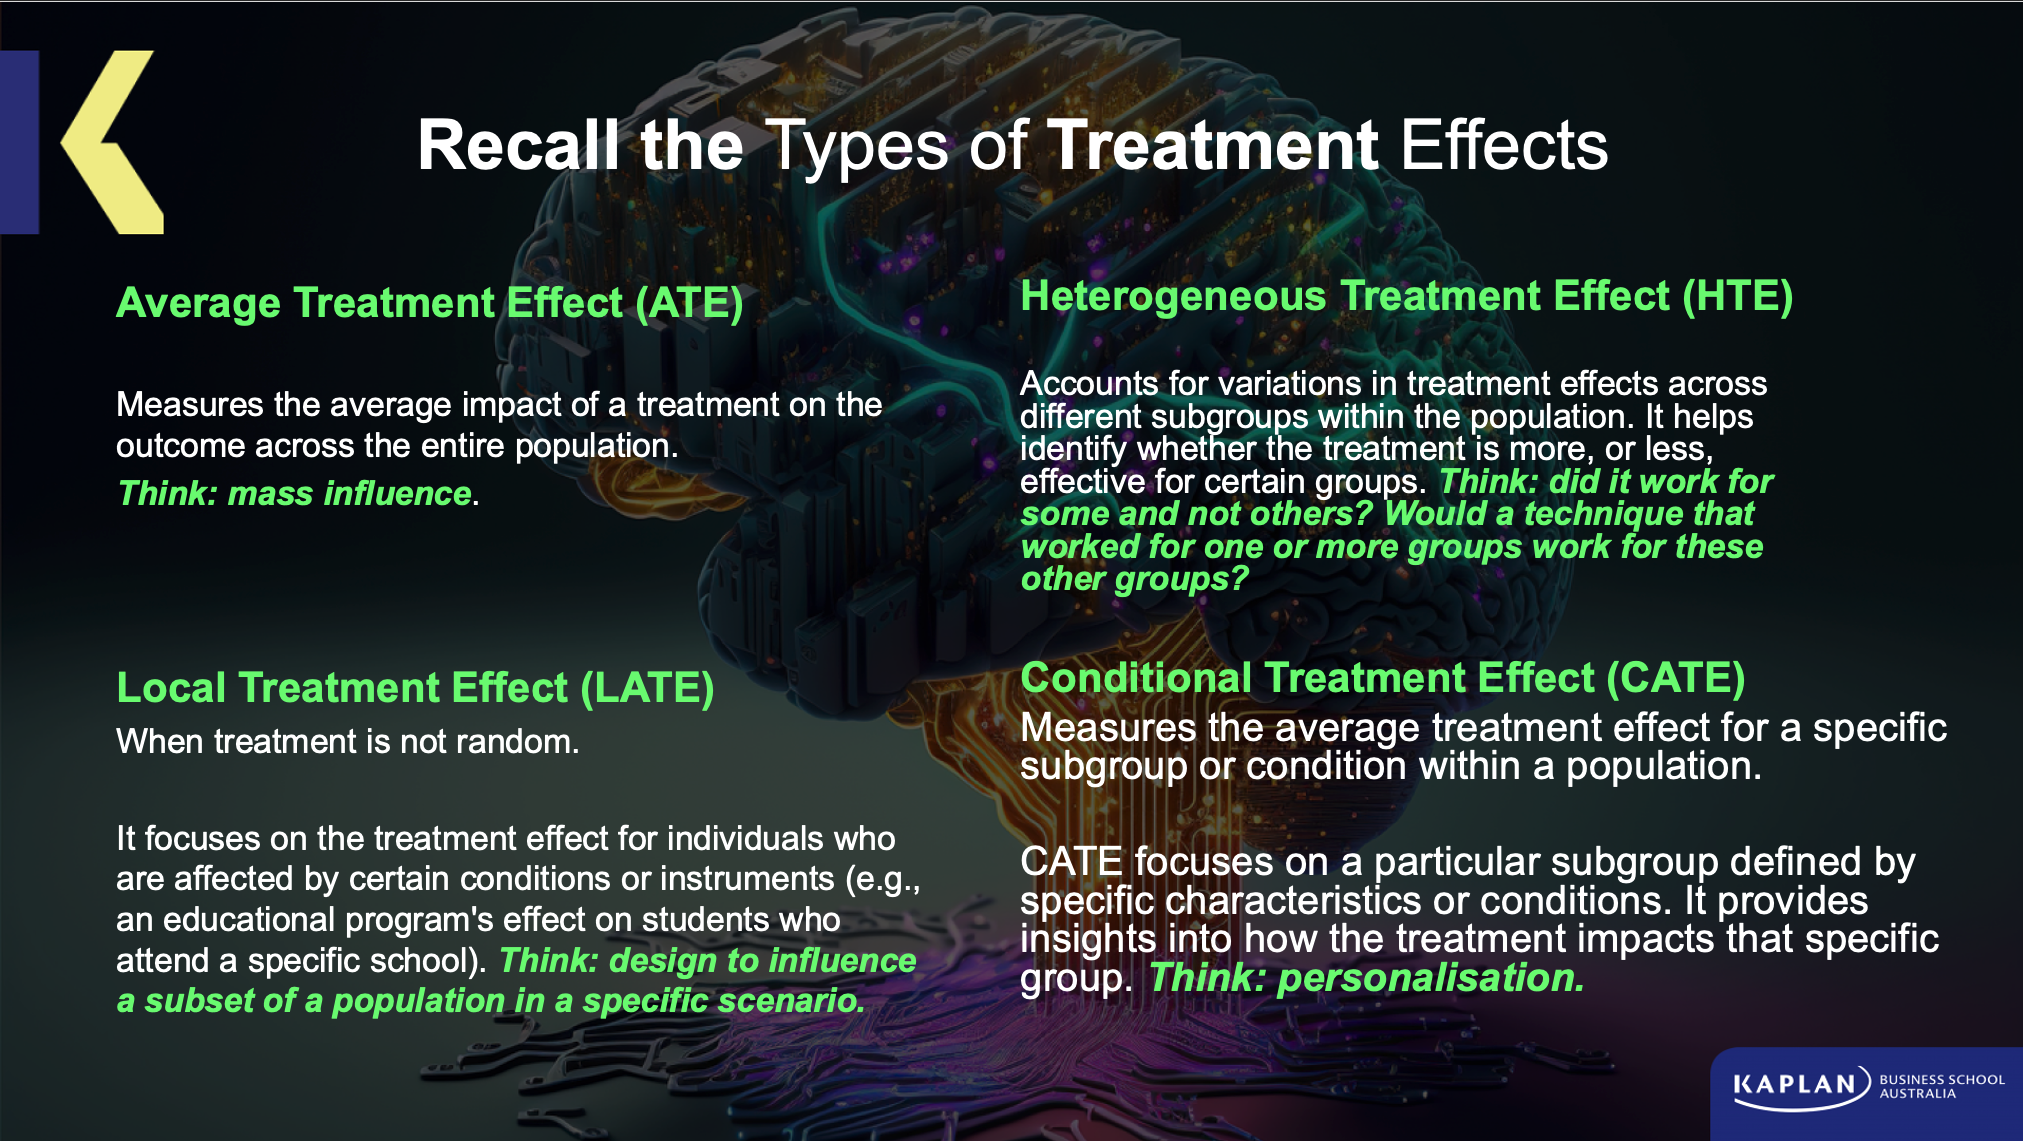

# We learn the **Average Treatment Effect (ATE)** for certain house characteristics (e.g. having a fireplace), assuming they are the treatment.

# The error bar above is ordered by **feature importance**, and the summary table above is ordered by **causal significance (p-value)**. Notice they are not in the exact same order. For example, the second most predictive feature, GrLivArea (total square footage), is only the fourth most causally significant feature.

# Segmentation -- How do different type of houses respond differently to having a fireplace?


## From the analysis above, we learned the direct effect of a few different house amenities on housing price at an average level.

## However, the effect of these house amenities on house price may vary by features like home age and zoning classification.

## In the following section, we are going to use the presence of a fireplace as an example to learn how different type of houses may increase in value with the addition of a fireplace.

In [ ]:
plt.figure(figsize=(12, 8))


causal_analysis.plot_heterogeneity_tree(
    x_test,
    "HasFireplace",
    max_depth=2,
    min_impurity_decrease=1e-6,
    min_samples_leaf = 5
)

# From the global level, we know that the ATE of having a fireplace is //$4391.217178 which means on average that having a fireplace will raise the housing price by //$4391.217178. In the shallow tree above, we can see although overall fireplaces already have a positive effect on housing price, the effect is even more dramatic on houses older than 75 years old.

# Policy Analysis -- What is the best policy considering cost?


## To take a step further, we'd like to know the sub-population where the treatment effect will still be positive after taking cost into consideration.

## Assuming the average cost of adding a fireplace is $2,500, let us see what kind of houses have a housing price that will increase more than their cost.  

In [ ]:
plt.figure(figsize=(12, 8))


causal_analysis.plot_policy_tree(
    x_test,
    "HasFireplace",
    treatment_costs=2500,
    max_depth=2,
    min_samples_leaf = 5
)

# You could see if we follow the recommended policy above, on average, the housing price will increase by \\$2,356 compared with no fireplace added. Similarly, it will increase by \\$465 compared with adding a fireplace for every house. To be more detailed, we could also output the individualized policy. In the following table, we will only print the top five houses ordered by policy gains.

In [ ]:
causal_analysis.individualized_policy(
    x_test,
    "HasFireplace",
    n_rows=5,
    treatment_costs=2500,
    alpha=0.1,
)

# Note that here the `effect of treatment` is the treatment effect of selecting one of the discrete treatment values minus the cost.

# In the treament column, 1 corresponds to having a fireplace, and 0 corresponds to no fireplace.

# What If Analysis - How does the overall housing price change if every home had a fireplace?


## The causal analysis tool could also answer **what if** types of questions. For a given treatment, we'd also like to know the **counterfactuals** if we intervene it in a different way. In the example below, we will learn how the overall housing price changes if every house in Ames had a fireplace.

In [ ]:
whatif_df = (
    x_test
    .loc[
        lambda df: df['HasFireplace'].eq(0)
    ]
)


whatif_y = y_test.loc[whatif_df.index]

counter_factual = causal_analysis.whatif(
    whatif_df,
    whatif_df['HasFireplace'].add(1).clip(upper = 1),
    'HasFireplace',
    whatif_y)

print("Current average housing price on test set: ", whatif_y.mean())

print(
    "Average housing price with one more room on test set: ",
    counter_factual["point_estimate"].mean(),
)

In [ ]:
# distribution comparison
plt.hist(counter_factual.point_estimate, label="With fireplace", alpha=0.7, weights=np.ones(len(whatif_y)) / len(whatif_y))

plt.hist(whatif_y, label="Without fireplace", alpha=0.7, weights=np.ones(len(whatif_y)) / len(whatif_y))

plt.legend()

plt.xlabel("Housing Price")


plt.title("Histogram of Housing price -- Current vs. One more room")

# From the summary table we could see overall if we add a fireplace to houses without fireplaces in the test set, the average housing price for those houses will increase by about \\$5k. And the histrogram shows a comparison between the current housing price distribution and the counterfactuals ditribution if we added a fireplace to the fireplace-less houses in the test set.

# Cohort Analysis -- What is the causal effect on a new dataset?
## The CausalAnalysis class can also help us learn the global and local causal effect of a new dataset given a trained model. From the two tables below, you can see the global effect on the test set is similar to that of the training set.

## And calculating the local effect gives you the heterogeneous treatment effect for each observation.

In [ ]:
# predict global effect
causal_analysis.cohort_causal_effect(x_test)

# Local Treatment Effect

## When treatment is not random.

In [ ]:
# predict local effect for each sub-group
causal_analysis.local_causal_effect(x_test)

# Complete Workshop :)